# INTRODUCTON/BUSINESS PROBLEM
In this project my main focus is on New York City and as we all know that it is the most populous city in the United States. With an estimated 2019 population of 8,336,817 distributed over about 302.6 square miles (784 km2), New York is also the most densely populated major city in the United States. New York City is a global hub of business and commerce, as a center for banking and finance, retailing, world trade, transportation, tourism, real estate, new media, traditional media, advertising, legal services, accountancy, insurance, theater, fashion, thus it attracts many people from all over the world and thus it forms the major entry point to the immigrants and therefore New York City's food culture includes an array of international cuisines influenced by the city's immigrant history.

My project will concentrate on following problems:

1. What is best place in New York City for Indian Cuisine?
2. Which is the best place to stay if you prefer Indian Cuisine?
3. Visualizing every parts of New York City that serves Indian foods
4. Which are the areas that lack Indian Restaurants?

## Target Audience
This project report would be beneficial for every person who wishes to try best Indian Cuisine in New York and looking to open  anew restaurent srving Indian dishes.

# DATA SECTION
By keeping the BUSINESS PROBLEM in mind which is mentioned in INTRODUCTION part,below are the required data and in this project there is a need following data:

1. New York City data that contains list of Boroughs, Neighbourhoods along with their location i.e. latitude and longitude.

    Data set is available here : "https://cocl.us/new_york_dataset" which is in JSON format.
    
    
2. Geospatial data are defined in the ISO/TC 211 series of standards as data and information having an implicit or explicit association with a location relative to Earth.

    Informaton regarding geospatial data is available at : "https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm"
    
    
3. Indian restaurants in each part/area of New York City.

    For this purpose I will be using Foursquare API

# CODING SECTION

## Libraries Required

### BeautifulSoup
Beautiful Soup is a Python library for pulling data out of HTML and XML files. It works with your favorite parser to provide idiomatic ways of navigating, searching, and modifying the parse tree. It commonly saves programmers hours or days of work

### Requests
Requests is a Python HTTP library, released under the Apache License 2.0. The goal of the project is to make HTTP requests simpler and more human-friendly. The current version is 2.23.0.Requests is one of the most popular python libraries that is not included with python, it has been proposed that requests be distributed with python by default.

### Pandas
pandas is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series. It is free software released under the three-clause BSD license.

### Numpy
Numpy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays

### Geocoder
Geocoder is a  python library which is used for computational process of transforming a physical address description to a location on the Earth’s surface (spatial representation in numerical coordinates)

### Folium
Folium is a powerful Python library that helps you create several types of Leaflet maps.It enables both the binding of data to a map for choropleth visualizations as well as passing rich vector/raster/HTML visualizations as markers on the map.The library has a number of built-in tilesets from OpenStreetMap, Mapbox, and Stamen, and supports custom tilesets with Mapbox or Cloudmade API keys. 

### Matplotlib
Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy. It provides an object-oriented API for embedding plots into applications using general-purpose GUI toolkits like Tkinter.

In [2]:
! pip install geocoder
! pip install folium

     |████████████████████████████████| 102kB 7.5MB/s ta 0:00:011
     |████████████████████████████████| 102kB 9.3MB/s ta 0:00:011


In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print('Libraries imported.')

Libraries imported.


### Function to get latitude, longitude

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### Utilizing the Foursquare API to get no. of top venues within given radius

For this I need following information:-
1. CLIENT ID
2. CLIENT SECRET
3. VERSION
4. LIMIT

In [62]:
def get_venues(latitude,longitude):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '' # your Foursquare ID
    CLIENT_SECRET = '' # your Foursquare Secret
    VERSION = '20200523' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            LIMIT)
    
    # get all the data
   
    venue_data=requests.get(url).json()["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [63]:
def get_venue_details(venue_id):
        
    CLIENT_ID ='' # your Foursquare ID
    CLIENT_SECRET = '' # your Foursquare Secret
    VERSION = '20200523' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
new_york_data.shape

(306, 4)

### Visualising above 306 Neighborhood by creating pie chart

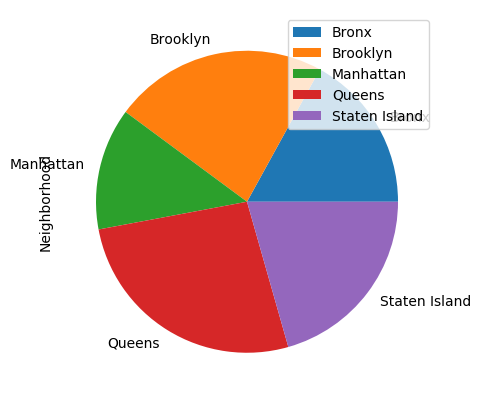

In [8]:
plt.figure(figsize=(9,5), dpi = 100)
#giving a bar plot
new_york_data.groupby('Borough',axis=0)['Neighborhood'].count().plot(kind = 'pie')
plt.legend(loc = 'upper right')
#displays the plot
plt.show()

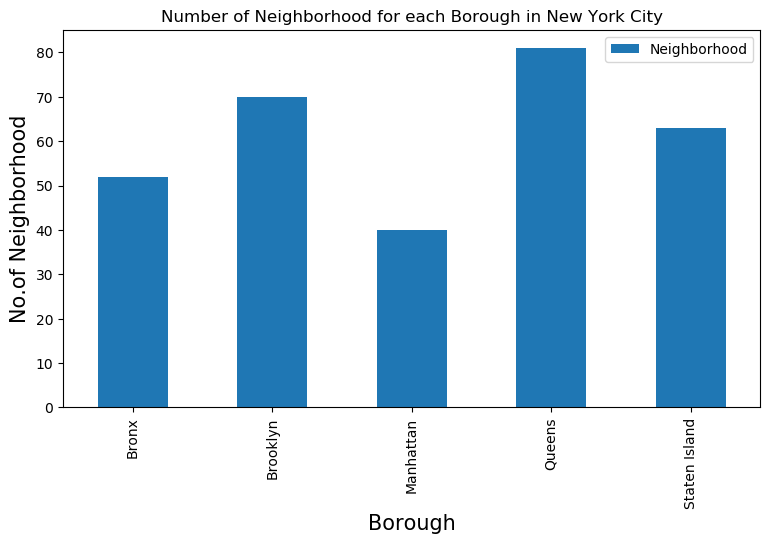

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Neighborhood for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

In [15]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

In [16]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [17]:
indian_rest_ny.shape

(146, 4)

In [27]:
indian_rest_ny.to_csv('indian_rest_ny.csv', index = False)

In [29]:
indian_rest_ny_csv = pd.read_csv('indian_rest_ny.csv')
indian_rest_ny_csv

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill
5,Bronx,Unionport,55dfa36a498e164ef19bef7b,Premium Sweets & Restaurant
6,Brooklyn,Bay Ridge,4b5a4dc8f964a520a2bb28e3,Taj Mahal
7,Brooklyn,Bay Ridge,545835a1498e820edc6f636f,Bombay Grill
8,Brooklyn,Brighton Beach,4af0d31bf964a5207ddf21e3,Pak Nasheman
9,Brooklyn,Flatbush,52213c4211d295d4c57a607c,Ashoka Grill


### Thus there are total 146 Indian Resturants across New York City

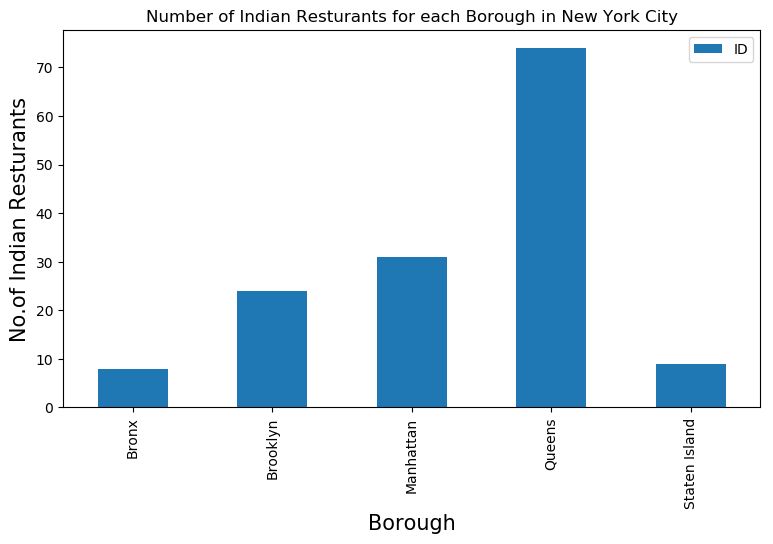

In [30]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny_csv.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From above bar plot it can be seen that Queens has highest number of Indian restaurents

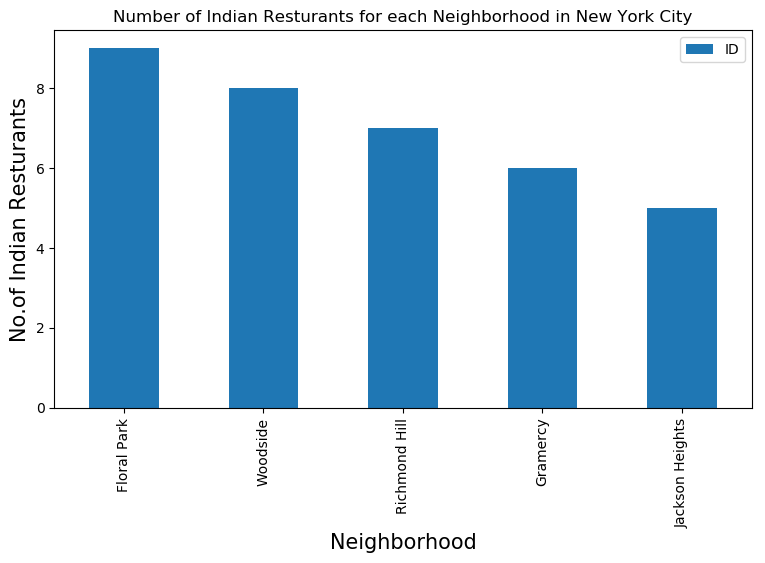

In [19]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


In [20]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
99,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
100,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
101,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
102,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
103,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
104,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
105,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
106,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
107,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


### It can be seen that "Floral Park" in Queens has the highest number of Indian Resturants with a total count of 9.

In [38]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.8    10
( 1 / 146 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 2 / 146 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.0     9
( 3 / 146 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.8     3
( 4 / 146 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 5 / 146 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 55dfa36a498e164ef19bef7b
( 6 / 146 ) processed
                         ID       Name  Likes  Rat

In [39]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.8,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.0,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.8,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [40]:
indian_rest_stats_ny.shape

(146, 7)

In [41]:
indian_rest_ny.shape

(146, 4)

In [42]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [43]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.8,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.0,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.8,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [44]:
indian_rest_stats_ny_csv.shape

(146, 7)

In [45]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 7 columns):
Borough         146 non-null object
Neighborhood    146 non-null object
ID              146 non-null object
Name            146 non-null object
Likes           146 non-null object
Rating          146 non-null float64
Tips            146 non-null object
dtypes: float64(1), object(6)
memory usage: 8.1+ KB


The Data type of 'Likes' and 'Tips' are of type 'String'therefore converting them into type 'Float' for further analysis.

In [46]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [47]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 7 columns):
Borough         146 non-null object
Neighborhood    146 non-null object
ID              146 non-null object
Name            146 non-null object
Likes           146 non-null float64
Rating          146 non-null float64
Tips            146 non-null float64
dtypes: float64(3), object(4)
memory usage: 8.1+ KB


Now finding the Indian restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [48]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               8.6
Tips                                 148
Name: 39, dtype: object

In [49]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood                     Astoria
ID              4aa56c81f964a5204e4820e3
Name                 Seva Indian Cuisine
Likes                                239
Rating                                 9
Tips                                 133
Name: 50, dtype: object

In [50]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a12eb1ff964a52099771fe3
Name                               Dhaba
Likes                                497
Rating                               8.3
Tips                                 164
Name: 47, dtype: object

In [51]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [52]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
0,Astoria,9.0
5,Blissville,9.0
26,Fort Greene,8.8
13,Clinton Hill,8.8
53,Prospect Heights,8.7
46,Murray Hill,8.6
71,Tudor City,8.6
70,Tribeca,8.6
12,Civic Center,8.6
33,Holliswood,8.5


### Above are the top neighborhoods with top average rating of Indian resturants.

Similarly we will find the average rating of Indian Resturants for each Borough.

In [53]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.170968
1,Brooklyn,7.737500
3,Queens,6.478378
0,Bronx,4.925000
4,Staten Island,3.555556


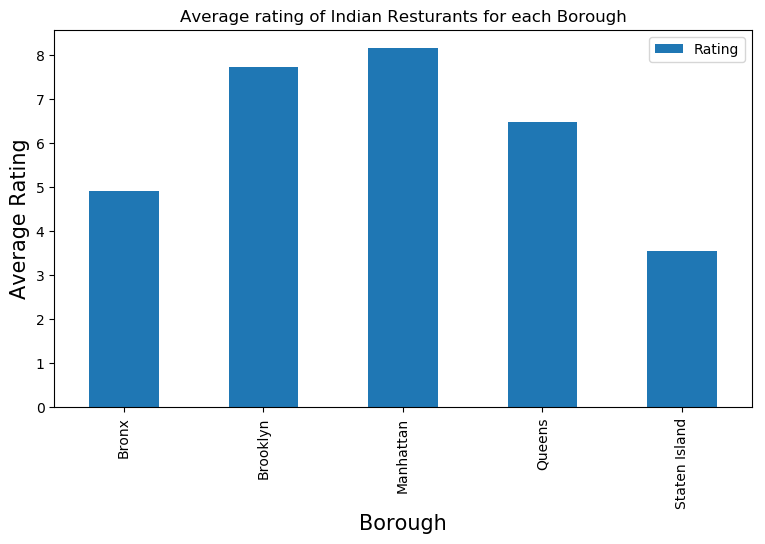

In [54]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map.

In [55]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [56]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,9.0
5,Blissville,9.0


We will join this dataset to original new york data to get lonitude and latitude.

In [57]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,9.0
1,Queens,Blissville,40.737251,-73.932442,9.0


## MAP

In [58]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose.

In [59]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [60]:

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

# Conclusion:

## From the anaysis here is the conclusion:

### 1) Astoria(Queens), Blissville(Queens) are the only 2 best neighborhoods for Indian cuisine.

### 2) Manhattan is the best place to stay if you prefer Indian Cuisine.

### 3) Manhattan have potential Indian Resturant Market

### 4) Staten Island ranks last in average rating of Indian Resturants.

### 5) Floral Park in Queens has the highest number of Indian Resturants.